# Single brain 3D Visualization

This notebook demonstrates how to visualize the cell density of each Region of Interest (ROI) in the mouse brain, utilizing data extracted in the preceding steps of the pipeline.

**Note**: the script is designed to run for one brain at a time. It is more exploraotry script than a generative one.

The notebook is split in 2 halves:
- In the first one 

### Instructions

1. **Set Up Your Environment:**
   To run this notebook, you need to create a virtual environment with the required packages. Follow these steps to set up your environment:

   - **Create a Virtual Environment:**
     Use the following command to create a virtual environment from the provided [brainrender-env.yml](assets/yml/brainrender-env.yml) file:
     ```bash
     conda env create -f brainrender-env.yml
     ```

   - **Activate the Environment:**
     Once created, activate the environment using:
     ```bash
     conda activate brainrender-env
     ```

   - **Select the Kernel:**
     After activating the environment, choose it as the kernel for the notebook. This ensures that all dependencies are correctly resolved when you run the notebook.

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import glob
from brainrender import Scene
from brainrender.actors import Points
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from brainglobe_atlasapi import BrainGlobeAtlas
from brainglobe_atlasapi import show_atlases
import brainglobe_heatmap as bgh
from brainrender import Scene, actors, cameras, settings


# Half Brain

### Mandatory Inputs

In [2]:
# Path to the csv file containing the cell density for the selected brain
csv_file = "/run/user/1000/gvfs/smb-share:server=upcourtinenas,share=cervical/CERVICAL_ID/Connectome_analysis/Final_dataset/DR/Uninjured/602/_Measurements/whole_brain.csv"

# Side of the brain where to extarct data
    # Even if both hemisphere will be displayed, the other one will contains the same values
side = "Left" #right

# Number of the first most dense roi to display
    # ATTENTION: more ROI you use, more it is difficultu to render the scene in 3D
    # we discourage plotting all the regions
n_roi_displayed = 20 #first most dense roi to display

#If normilze the color of the rendering
    # we advise to do so, otherwhise all ROI will have same color
normalize_color = True

verbose = True


### Prepare Data

Here we will
    - Choose which region to plot (only the first most dense)
    - Scale the color used to render them (otherwise due to very low densities, they will bedisplayed all as white)

In [3]:
# Read csv file
df = pd.read_csv(csv_file)

# Take the ROI only from one side
df = df[df["Side"] == side]

# Take only first most dense regions
df = df.sort_values(by='Cell Density', ascending=False)
df = df.iloc[:n_roi_displayed, :] #take first elements

# Create the dictionary --> NB take the name withounf left or right
cell_density_data = dict(zip(df['Region'], df['Cell Density']))
    #cell_density_data = {"VISp": 50,"CA1": 30,"M1": 65,"S1": 90,"SCop":100}

if normalize_color:
    # Normalize cell density values to range [0, 1]
    def normalize(value, min_value, max_value):
        return (value - min_value) / (max_value - min_value)
    min_density = min(cell_density_data.values())
    max_density = max(cell_density_data.values())
    normalized_densities = {region: normalize(density, min_density, max_density) for region, density in cell_density_data.items()}

    # Create a colormap using matplotlib
    cmap = plt.get_cmap('Reds')  # You can choose other colormaps like 'plasma', 'inferno', etc.
    norm = mcolors.Normalize(vmin=0, vmax=1)

    # Map normalized densities to colors
    colors = {region: mcolors.to_hex(cmap(norm(density))) for region, density in normalized_densities.items()}

    # Colors in rgb triplets
    rgb_colors = {region: cmap(norm(density)) for region, density in normalized_densities.items()} 
else:
    colors = cell_density_data
    rgb_colors = {region: cmap(density) for region, density in colors.items()}

print(colors)
print(rgb_colors)


{'LDT': '#67000d', 'dscp': '#e63328', 'DR': '#ee3a2c', 'IF': '#f03f2e', 'MMd': '#f14331', 'PN': '#f96044', 'SG': '#f96044', 'PCG': '#fb7858', 'CS': '#fc8060', 'VI': '#fc8969', 'IPL': '#fc8f6f', 'AT': '#fc9b7c', 'IPDL': '#fcb499', 'VTN': '#fcb99f', 'pm': '#fcb99f', 'IPRL': '#fcc2aa', 'IPA': '#fdd5c4', 'SUM': '#fee1d4', 'RAmb': '#fee7db', 'RM': '#fff5f0'}
{'LDT': (0.403921568627451, 0.0, 0.05098039215686274, 1.0), 'dscp': (0.9034832756632064, 0.19853902345251828, 0.15847750865051902, 1.0), 'DR': (0.9344867358708189, 0.2286812764321415, 0.17139561707035755, 1.0), 'IF': (0.9407612456747405, 0.24510572856593618, 0.18131487889273357, 1.0), 'MMd': (0.9451903114186851, 0.26245290272971933, 0.19238754325259516, 1.0), 'PN': (0.974717416378316, 0.37810073048827375, 0.26620530565167244, 1.0), 'SG': (0.974717416378316, 0.37810073048827375, 0.26620530565167244, 1.0), 'PCG': (0.9857285659361784, 0.4722798923490965, 0.34678969627066514, 1.0), 'CS': (0.9864667435601692, 0.5018069973087274, 0.3763168012

### Plot the color to be used for rendering

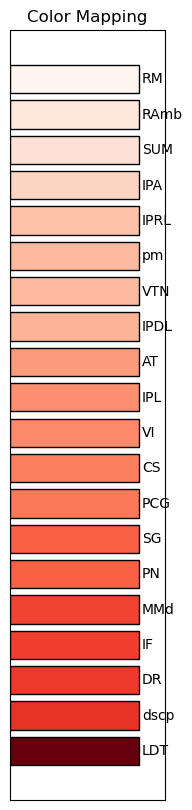

In [4]:
# Plot the colors
fig, ax = plt.subplots(figsize=(2,10))  # Adjust the size as needed

# Create a list of color names and their corresponding colors
regions = list(colors.keys())
color_values = list(color for color in rgb_colors.values())

# Create a bar plot to show the colors
for i, (region, color) in enumerate(rgb_colors.items()):
    ax.barh(i, 1, color=color, edgecolor='black')
    ax.text(1.02, i, region, va='center', ha='left')

# Remove axes and labels for better visualization
ax.set_xlim(0, 1.2)
ax.set_yticks([])
ax.set_xticks([])
ax.set_title('Color Mapping')

plt.show()

### Choose Atlas
Check here atlas available: [link](https://brainglobe.info/documentation/brainglobe-atlasapi/index.html)

In [5]:
# SHow all atlases supported by brainrender
show_atlases()

# Select an atlas
bg_atlas = BrainGlobeAtlas("allen_mouse_50um", check_latest=False)

# Show atlas choosen
#print(bg_atlas)

# List all brain regions in the atlas
#print(bg_atlas.lookup_df)

╭───────────────────────────────── Brainglobe Atlases ─────────────────────────────────╮
│                                                                           Latest     │
│  Name                              Downloaded  Updated  Local version    version     │
│  kim_mouse_100um                       ✔          ✔          1.1           1.1       │
│  allen_mouse_25um                      ✔          ✔          1.2           1.2       │
│  allen_mouse_50um                      ✔          ✔          1.2           1.2       │
│  example_mouse_100um                                                       1.2       │
│  allen_mouse_10um                                                          1.2       │
│  allen_mouse_100um                                                         1.2       │
│  mpin_zfish_1um                                                            1.0       │
│  allen_human_500um                                                         1.0       │
│  kim_mouse_10um                                                            1.1       │
│  kim_mouse_25um                                                            1.1       │
│  kim_mouse_50um                                                            1.1       │
│  osten_mouse_10um                                                          1.1       │
│  osten_mouse_25um                                                          1.1       │
│  osten_mouse_50um                                                          1.1       │
│  osten_mouse_100um                                                         1.1       │
│  allen_cord_20um                                                           1.1       │
│  azba_zfish_4um                                                            1.2       │
│  whs_sd_rat_39um                                                           1.2       │
│  perens_lsfm_mouse_20um                                                    1.2       │
│  admba_3d_e11_5_mouse_16um                                                 1.1       │
│  admba_3d_e13_5_mouse_16um                                                 1.1       │
│  admba_3d_e15_5_mouse_16um                                                 1.1       │
│  admba_3d_e18_5_mouse_16um                                                 1.1       │
│  admba_3d_p4_mouse_16.752um                                                1.1       │
│  admba_3d_p14_mouse_16.752um                                               1.1       │
│  admba_3d_p28_mouse_16.752um                                               1.1       │
│  admba_3d_p56_mouse_25um                                                   1.1       │
│  princeton_mouse_20um                                                      1.1       │
│  kim_dev_mouse_stp_10um                                                    1.2       │
│  kim_dev_mouse_idisco_10um                                                 1.2       │
│  kim_dev_mouse_mri_a0_10um                                                 1.2       │
│  kim_dev_mouse_mri_adc_10um                                                1.2       │
│  kim_dev_mouse_mri_dwi_10um                                                1.2       │
│  kim_dev_mouse_mri_fa_10um                                                 1.2       │
│  kim_dev_mouse_mri_mtr_10um                                                1.2       │
│  kim_dev_mouse_mri_t2_10um                                                 1.2       │
│  sju_cavefish_2um                                                          1.0       │
│  allen_mouse_bluebrain_barrels_1…                                          1.0       │
│  allen_mouse_bluebrain_barrels_2…                                          1.0       │
│  unam_axolotl_40um                                                         1.0       │
│  oldenburg_blackcap_25um                                                   0.1       │
╰───────────────────────────────────────────────────────────────────────────────────

### Visualize

#### With only BrainRender - Only one Hemisphere

In [6]:
# Necessary for running in jupyternotebook
import vedo
vedo.settings.default_backend= 'vtk'

# Display the Allen Brain mouse atlas.
scene = Scene(atlas_name="allen_mouse_50um", title="Cells Density in differnt brain regions")

# Add each brain region with the corresponding color
for region, color in colors.items():
    scene.add_brain_region(region, alpha=0.7, color=color)

# Add label to the brain region
#scene.add_label(primary_visual, "Primary visual cortex")

# Display the figure.
scene.render()

#### With Napari - Only one Hemisphere

In [7]:
from brainrender_napari.napari_atlas_representation import NapariAtlasRepresentation
from brainglobe_atlasapi import BrainGlobeAtlas
import napari


viewer = napari.Viewer()
viewer.dims.ndisplay = 3
# replace "mpin_zfish_1um" with atlas of interest below
napari_atlas = NapariAtlasRepresentation(bg_atlas, viewer)
napari_atlas.add_to_viewer()

# Change who is shown
layer = viewer.layers["allen_mouse_50um_annotation"]
layer.visible = False
layer = viewer.layers["allen_mouse_50um_reference"]
layer.visible = True


for region, color in rgb_colors.items(): #Attention: here colors are rgb

    if not (region in bg_atlas.lookup_df["acronym"].to_list()):
        print(f"Region {region} not present in the atlas.")
        continue

    print(f"Renderinf region {region}...")

    # Add region as mesh
    napari_atlas.add_structure_to_viewer(region)

    #Change name mesh just added (it is a layer in napari)
    viewer.layers[-1].name = region

    #Change color mesh
    surface_layer = viewer.layers[-1] # get the vertex layer
    n_vertices = len(surface_layer.vertex_colors) # find number of vertices in the surface layer
    surface_layer.vertex_colors = np.repeat([color], n_vertices, axis=0) # make the surface layer red (1, 0, 0)


napari.run()

/home/gabri/mambaforge/envs/brainrender-env/lib/python3.9/site-packages/brainrender_napari/napari_atlas_representation.py:24: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.6.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self._tooltip = QLabel(self.viewer.window.qt_viewer.parent())


Renderinf region LDT...
Renderinf region dscp...
Renderinf region DR...
Renderinf region IF...
Renderinf region MMd...
Renderinf region PN...
Renderinf region SG...
Renderinf region PCG...
Renderinf region CS...
Renderinf region VI...
Renderinf region IPL...
Renderinf region AT...
Renderinf region IPDL...
Renderinf region VTN...
Renderinf region pm...
Renderinf region IPRL...
Renderinf region IPA...
Renderinf region SUM...
Renderinf region RAmb...
Renderinf region RM...


# Whole brain - 2 different Hemispheres

Here we:
- Disply in 3D a brain where the 2 hemisphres have different values

**Render Setting**: please play  with the render setting in this notebook cell to achieve the visual aesthetic that you most prefer.
    
**ATTENTION**: it cannot handle too many regions!!!, so it is only possbile to plot a subset of them.

## Easy way

In [4]:
import pandas as pd
import numpy as np
import glob
from brainrender import Scene
from brainrender.actors import Points
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from brainglobe_atlasapi import BrainGlobeAtlas
from brainglobe_atlasapi import show_atlases
import brainglobe_heatmap as bgh
from brainrender import Scene, actors, cameras, settings


# MANDATORY INPUTS
csv_file = "/run/user/1000/gvfs/smb-share:server=upcourtinenas,share=cervical/CERVICAL_ID/Connectome_analysis/Final_dataset/DR/Uninjured/602/_Measurements/whole_brain.csv"
image_dir = "" #folder where to save images
#side = "Left"
n_roi_displayed = 10 #first most dense roi to display
verbose = True
#If normilze the color of the rendering
    # we advise to do so, otherwhise all ROI will have same color
normalize_color = True
#coloramp
cmap = plt.get_cmap('Reds')  # You can choose other colormaps like 'plasma', 'inferno', etc.


#####################################
### Necessary for running in jupyter
import vedo
vedo.settings.default_backend= 'vtk'

#####################################
### Decide which region to plot

# We decide to take the first n_roi_displayed more dense independenly of left or right, and then take also the contalater part
df = pd.read_csv(csv_file)
df_sorted = df.sort_values(by='Cell Density', ascending=False)
df_sorted_max = df_sorted.iloc[:n_roi_displayed, :] #take first elements
name_max_regions = df_sorted_max["Region"].to_list()
print(name_max_regions)

#####################################
### choose Atlas
bg_atlas = BrainGlobeAtlas("allen_mouse_50um", check_latest=False)

#####################################
### Ectract the density of the regions decided in the cell above

df = pd.read_csv(csv_file)
# Take the ROI only from one side
df = df[df["Side"] == "Left"]
# Take only first most dense regions
df = df[df["Region"].isin(name_max_regions)]
# Only the ROI that are presnet in the atlas otherwise we will have errors
df = df[df['Region'].isin(bg_atlas.lookup_df["acronym"].to_list())] #take only regions that are in the atlas
# Create the dictionary --> NB take the name withounf left or right
cell_density_data = dict(zip(df['Region'], df['Cell Density']))
cell_density_data_left = cell_density_data

df = pd.read_csv(csv_file)
# Take the ROI only from one side
df = df[df["Side"] == "Right"]
# Take only first most dense regions
df = df[df["Region"].isin(name_max_regions)]
# Only the ROI that are presnet in the atlas otherwise we will have errors
df = df[df['Region'].isin(bg_atlas.lookup_df["acronym"].to_list())] #take only regions that are in the atlas
# Create the dictionary --> NB take the name withounf left or right
cell_density_data = dict(zip(df['Region'], df['Cell Density']))
cell_density_data_right = cell_density_data

print(cell_density_data_left)
print(cell_density_data_right)

#####################################
### create colors

# Normalize cell density values to range [0, 1]
def normalize(value, min_value, max_value):
    return (value - min_value) / (max_value - min_value)

if normalize_color:
    array_left = np.array(list(cell_density_data_left.values()))
    array_right = np.array(list(cell_density_data_right.values()))
    all_densities = np.concatenate((array_left, array_right))
    min_density = all_densities.min()
    max_density = all_densities.max()
    normalized_densities_left = {region: normalize(density, min_density, max_density) for region, density in cell_density_data_left.items()}
    normalized_densities_right = {region: normalize(density, min_density, max_density) for region, density in cell_density_data_right.items()}

    # Create a colormap using matplotlib
    cmap = plt.get_cmap('Reds')  # You can choose other colormaps like 'plasma', 'inferno', etc.
    norm = mcolors.Normalize(vmin=0, vmax=1)

    # Map normalized densities to colors
    colors_left = {region: mcolors.to_hex(cmap(norm(density))) for region, density in normalized_densities_left.items()}
    colors_right = {region: mcolors.to_hex(cmap(norm(density))) for region, density in normalized_densities_right.items()}
else:
    colors_left = cell_density_data_left
    colors_right = cell_density_data_right
    rgb_colors_left = {region: cmap(density) for region, density in colors_left.items()}
    rgb_colors_right = {region: cmap(density) for region, density in colors_right.items()}


print(colors_left)
print(colors_right)

# Colors in rgb triplets
#rgb_colors = {region: mcolors.to_rgb(cmap(norm(density))) for region, density in normalized_densities.items()}
#print(rgb_colors)

############################################
### Change paramters for rendering

# settings.SHADER_STYLE = "plastic"  # Options: 'plastic', 'metallic', 'shiny', 'matte'
# settings.BACKGROUND_COLOR = "black"  # Any color name or RGB hex code
# settings.ROOT_ALPHA = 0.4  # Value between 0 (fully transparent) and 1 (fully opaque)
# settings.SHOW_AXES = False  # True or False
# settings.SHOW_LEGEND = True  # True or False
# settings.SHOW_SCALEBAR = True  # True or False

#settings.WINDOW_SIZE = [800, 600]  # Width, Height in pixels
#settings.CAMERA = {
    #"pos": (0, 0, 0),
    #"viewup": (0, -1, 0),
    #"clippingRange": (2000, 10000),
    #"focalPoint": (0, 0, 0),
    #"distance": 5000 }

#brainrender.reset_defaults()

custom_camera = {
    "pos": (0, 4000, -5700), #(x,up/doen,left/rught)
    "viewup": (0, -1, 0),
    "clipping_range": (2000, 10000)
}

############################################
### render scene

# Display the Allen Brain mouse atlas.
scene = Scene(atlas_name="allen_mouse_50um", title="Cells Density in differnt brain regions",)

# Create 2 differt scenes
scene_left = Scene(atlas_name="allen_mouse_50um", title="Cells Density in differnt brain regions")
scene_right = Scene(atlas_name="allen_mouse_50um", title="Cells Density in differnt brain regions")

# Add each brain region with the corresponding color
for region, color in colors_right.items():
    scene_right.add_brain_region(region, alpha=1, color=color, hemisphere="right")
for region, color in colors_left.items():
    scene_left.add_brain_region(region, alpha=1, color=color, hemisphere="left")

# Create a new Scene for integration
new_scene = Scene(title="Combined Brain Visualization")

# Add the extracted brain actors to the new scene
def extract_brain_actors(scene: Scene):
    # Function to extract actors from the heatmap scene
    return [actor for actor in scene.get_actors(br_class="brain region")]
for actor in extract_brain_actors(scene_left):
    new_scene.add(actor)
for actor in extract_brain_actors(scene_right):
    new_scene.add(actor)

# Render the new scene
new_scene.render(camera=custom_camera)



['mfb', 'SUM', 'VTN', 'VI', 'Su3', 'CUN', 'LDT', 'DR', 'dscp', 'MMd']
{'MMd': 0.0043683729796274, 'SUM': 0.0026602997854264, 'Su3': 0.0014067335646628, 'CUN': 0.0011996284497383, 'VTN': 0.0031474698141364, 'DR': 0.0044524537553373, 'LDT': 0.005768558867203, 'VI': 0.0036721884666247, 'dscp': 0.0045453033712847, 'mfb': 0.0011892146448107}
{'MMd': 0.0059847232065516, 'SUM': 0.0098050949938592, 'Su3': 0.0089835728952772, 'CUN': 0.0081535399534851, 'VTN': 0.0097714100755452, 'DR': 0.0067155854201417, 'LDT': 0.0081345507042349, 'VI': 0.0091580076530203, 'dscp': 0.005998330899228, 'mfb': 0.013460350991524}
{'MMd': '#fcb89e', 'SUM': '#fee1d4', 'Su3': '#fff2ec', 'CUN': '#fff5f0', 'VTN': '#fdd7c6', 'DR': '#fcb69b', 'LDT': '#fc9373', 'VI': '#fdcab5', 'dscp': '#fcb398', 'mfb': '#fff5f0'}
{'MMd': '#fc8d6d', 'SUM': '#d92523', 'Su3': '#ec382b', 'CUN': '#f4503a', 'VTN': '#d92523', 'DR': '#fb7a5a', 'LDT': '#f5523a', 'VI': '#e83429', 'dscp': '#fc8d6d', 'mfb': '#67000d'}


### Video with "Animation" in Brainrender - Frontal View

In [ ]:

import os
from brainrender import Scene, Animation
import numpy as np
import vedo
vedo.settings.default_backend= 'vtk'


# Function to extract brain actors
def extract_brain_actors(scene: Scene):
    # Function to extract actors from the heatmap scene
    return [actor for actor in scene.get_actors(br_class="brain region")]

# Initialize the scene
scene = new_scene

# Define the custom camera position (replace with your desired position)
custom_camera = {
    "pos": (0, 4000, -5700), #(x,up/doen,left/rught)
    "viewup": (0, -1, 0),
    "clipping_range": (2000, 10000)
}

# Create the Animation instance
anim = Animation(scene, "/home/gabri/Downloads/temp", "brainrender_animation", fmt="mp4")

# Define a custom callback function for slicing
    # step = 100
    # inzitl x offset = -100
def slicing_callback(scene, frame_number, total_frames, **kwargs):
    x_cut = 3000 + frame_number * 200  # Starting at 5000, incrementing by 100 per frame
    plane = scene.atlas.get_plane(pos=(x_cut, 0, 0), norm=(1, 0, 0))
    scene.slice(plane, actors=extract_brain_actors(scene))
    return custom_camera

# Add keyframes with the slicing callback
total_duration = 4  # seconds
fps = 10
num_frames = total_duration * fps

for i in range(num_frames):
    time = i / fps  # Calculate the time in seconds for each frame
    anim.add_keyframe(time, camera=custom_camera, callback=slicing_callback)

# Make the video
anim.make_video(duration=total_duration, fps=fps)


### Video with "VideoMaker" in Brainrender - Lateral View

In [ ]:
from brainrender.video import VideoMaker
import vedo
vedo.settings.default_backend= 'vtk'

s = new_scene
s.plotter.camera.position = (0, 4000, -5700)


# Make a custom make frame function
def make_frame(s, frame_number, *args, **kwargs):

    x_cut = 100*frame_number
    offset = 0

    s.plotter.camera.position = (0, 4000, -5700)
    #print(f"Frame {frame_number}: Camera position: {s.plotter.camera.position}")
    #print(x_cut)
    #print(s.camera)

    plane = s.atlas.get_plane(pos=(x_cut + offset,0,0), norm=(1, 0, 0))
    s.slice(plane, actors=extract_brain_actors(s))



# Now make a video with our custom function
vm = VideoMaker(s, "/home/gabri/Downloads/temp", "vid1", make_frame_func=make_frame)
vm.make_video(duration=9, fps=15)



## Difficult Way
**ATTENTION**: To correctly execute this part of the process, you must modify the `render()` function in the `heatmap.py` script. This file is located in the `brainrender-env/lib/python3.9/site-packages/brainglobe_heatmap` directory of your virtual environment.

For a visual guide on how to perform this modification, refer to the image below:

<div style="text-align: center;">
    <img src="/home/gabri/Desktop/intership_neurorestore_pipeline/assets/images/modify_render_heatmap_script.png" alt="Modify Render Function" width="500"/>
</div>



In [ ]:
# Firstly we have to decide which region to plot
# We decide to take the first n_roi_displayed more dense independenly of left or right, and then take also the contalater part

df = pd.read_csv(csv_file)

df_sorted = df.sort_values(by='Cell Density', ascending=False)
df_sorted_max = df_sorted.iloc[:n_roi_displayed, :] #take first elements

name_max_regions = df_sorted_max["Region"].to_list()

print(name_max_regions)

['mfb', 'VTN', 'VI', 'Su3', 'CUN', 'LDT', 'DR', 'MMd', 'PCG', 'AT', 'IF', 'LDT', 'PN', 'PIL', 'gVIIn', 'pm', 'DR', 'IF', 'Pa4', 'MMd']


In [ ]:
#####################################
### Necessary for running in jupyter
import vedo
vedo.settings.default_backend= 'vtk'

#####################################
### Prepare data to show --> 2 of them: one left, one right

df = pd.read_csv(csv_file)
# Take the ROI only from one side
df = df[df["Side"] == "Left"]
# Take only first most dense regions
df = df[df["Region"].isin(name_max_regions)]
# Only the ROI that are presnet in the atlas otherwise we will have errors
df = df[df['Region'].isin(bg_atlas.lookup_df["acronym"].to_list())] #take only regions that are in the atlas
# Create the dictionary --> NB take the name withounf left or right
cell_density_data = dict(zip(df['Region'], df['Cell Density']))
cell_density_data_left = cell_density_data

df = pd.read_csv(csv_file)
# Take the ROI only from one side
df = df[df["Side"] == "Right"]
# Take only first most dense regions
df = df[df["Region"].isin(name_max_regions)]
# Only the ROI that are presnet in the atlas otherwise we will have errors
df = df[df['Region'].isin(bg_atlas.lookup_df["acronym"].to_list())] #take only regions that are in the atlas
# Create the dictionary --> NB take the name withounf left or right
cell_density_data = dict(zip(df['Region'], df['Cell Density']))
cell_density_data_right = cell_density_data

print(cell_density_data_left)
print(cell_density_data_right)


#####################################
### prepare 2 actors

sagittal_middle = 5700

left_hm = bgh.Heatmap(
    cell_density_data_left,
    position=(
        sagittal_middle #None is centered in the brain
    ),
    orientation="sagittal",  # 'frontal' or 'sagittal', or 'horizontal' or a tuple (x,y,z)
    title="sagittal left",
    vmin=0,
    vmax=0.01,
    cmap='Reds',
    format="3D",
    thickness = 10000 # in order to see every region
)

right_hm = bgh.Heatmap(
    cell_density_data_right,
    position=(
        8000,
        5000,
        sagittal_middle
    ),
    orientation=(0,0,-1),  # 'frontal' or 'sagittal', or 'horizontal' or a tuple (x,y,z)
        #NB to change the point of view using a tuple, tu MUST chnage the heatmpas.py inside the pacakce "brainglobe_heatmap"
    title="sagittal right",
    vmin=0,
    vmax=0.01,
    cmap='Reds',
    format="3D",
    thickness = 10000 # in order to see every region
)

scene_left = left_hm.show()
scene_right = right_hm.show()

def extract_brain_actors(scene: Scene):
    # Function to extract actors from the heatmap scene
    return [actor for actor in scene.get_actors(br_class="brain region")]

# Create a new Scene for integration
new_scene = Scene(title="Combined Brain Visualization")

# Add the extracted brain actors to the new scene
for actor in extract_brain_actors(scene_left):
    new_scene.add(actor)
for actor in extract_brain_actors(scene_right):
    new_scene.add(actor)

# Render the new scene
new_scene.render()





{'PIL': 0.0010510530237481, 'MMd': 0.0043683729796274, 'PN': 0.0041010451969356, 'Su3': 0.0014067335646628, 'CUN': 0.0011996284497383, 'Pa4': 0.0016606973821873, 'VTN': 0.0031474698141364, 'AT': 0.0034706583653464, 'IF': 0.0044176676238279, 'DR': 0.0044524537553373, 'PCG': 0.0038510489600164, 'LDT': 0.005768558867203, 'VI': 0.0036721884666247, 'gVIIn': 0.0016057782829507, 'mfb': 0.0011892146448107, 'pm': 0.003140800334088}
{'PIL': 0.0049753925377404, 'MMd': 0.0059847232065516, 'PN': 0.0053520513039112, 'Su3': 0.0089835728952772, 'CUN': 0.0081535399534851, 'Pa4': 0.0043882222282417, 'VTN': 0.0097714100755452, 'AT': 0.0058738868149335, 'IF': 0.0058395932002866, 'DR': 0.0067155854201417, 'PCG': 0.0059275339849265, 'LDT': 0.0081345507042349, 'VI': 0.0091580076530203, 'gVIIn': 0.0048593157328602, 'mfb': 0.013460350991524, 'pm': 0.004469972303701}


## Check where yuo are cutting

In [ ]:
"""
    This example shows how to use the `plan` functionality to visualize the
    position of the planes used to 'slice' the brain for heatmap visualization.
"""

import brainglobe_heatmap as bgh

regions = [
    "TH",
    "RSP",
    "AI",
    "SS",
    "MO",
    "PVZ",
    "LZ",
    "VIS",
    "AUD",
    "RHP",
    "STR",
    "CB",
    "FRP",
    "HIP",
    "PA",
]


planner = bgh.plan(
    regions,
    position=(
        8000,
        5000,
        5700,
    ),
    orientation=(0,0,-1),  # or 'sagittal', or 'horizontal' or a tuple (x,y,z)
    thickness=2000,  # thickness of the slices used for rendering (in microns)
    arrow_scale=750,
)
planner.show()


╭─ Plane 0 ─────────────────────────────╮
│                                       │
│   center point:  (8000, 5000, -5700)  │
│           norm:  (0.0, 0.0, -1.0)     │
│              u:  (-1.0, 0.0, 0.0)     │
│              v:  (0.0, 1.0, 0.0)      │
╰───────────────────────────────────────╯

╭─ Plane 1 ─────────────────────────────╮
│                                       │
│   center point:  (8000, 5000, -7700)  │
│           norm:  (0.0, 0.0, 1.0)      │
│              u:  (1.0, 0.0, 0.0)      │
│              v:  (0.0, 1.0, 0.0)      │
╰───────────────────────────────────────╯

A `brainrender.scene.Scene` with 19 actors.

# Tests

In [3]:
from brainrender import camera

s= new_scene

custom_camera = {
    "pos": (0, 4000, -5700), #(x,up/doen,left/rught)
    "viewup": (0, -1, 0),
    "clipping_range": (2000, 10000)
}

print(camera.get_camera_params(s))
camera.set_camera(s, custom_camera)
print(camera.get_camera_params(s))

plane = s.atlas.get_plane(pos=(5000,0,0), norm=(1, 0, 0))

s.slice(plane, actors=extract_brain_actors(s))

print(camera.get_camera_params(s))
camera.set_camera(s, custom_camera)
print(camera.get_camera_params(s))

s.render(custom_camera)

{'pos': (-13934, -5041, 10160), 'focal_point': (9096, 3849, -5688), 'viewup': (0, -1, 0), 'distance': 29335, 'clipping_range': (14809, 47692)}
{'pos': (0, 4000, -5700), 'focal_point': (9096, 3849, -5688), 'viewup': (0, -1, 0), 'distance': 9098, 'clipping_range': (2000, 10000)}
{'pos': (0, 4000, -5700), 'focal_point': (9096, 3849, -5688), 'viewup': (0, -1, 0), 'distance': 9098, 'clipping_range': (2000, 10000)}
{'pos': (0, 4000, -5700), 'focal_point': (9096, 3849, -5688), 'viewup': (0, -1, 0), 'distance': 9098, 'clipping_range': (2000, 10000)}


In [5]:
s = Scene()

# Define custom camera settings (this is an example; adjust based on your needs)
def custom_camera(scene):
    # Example of setting a camera view, adjust parameters as needed
    scene.camera.position = [100, 100, 100]  # Camera position in 3D space
    scene.camera.focal_point = [0, 0, 0]  # Point the camera is looking at
    scene.camera.up_vector = [0, 0, 1]  # Up direction for the came